# <font color = 'red'> ЛР 8. Наивный баесовский классификатор. Калибровка вероятностей в моделях классификации</font>

Сложность: <font color = 'red'> Сложно  </font>.

Дата составления: 14.11.2024

Срок выполнения: 1 неделя (с момента первой практики после выдачи).

Автор: ст. преподаватель Кушнеров А.В.

In [42]:
import numpy as np
import pandas as pd
import re
from scipy.stats import entropy
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree as treeplt
from sklearn.datasets import make_classification, make_blobs, make_regression, load_digits
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression


RANDOM_STATE: int = 54

## <font color = 'green'> 1. Наивный Байесовский классификатор </font>

Наивный Байесовский классификатор — это условная модель позволяющая на основе исходных данных вычислить вероятности попадания в класс тестового сэмпла и принять решение о классификации на основе вероятности.

Подробнее см лекционные записи.


Несколько полезных ссылок. 

1. [Годная статья на вики](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
2. [Альтернатива](https://medium.com/@kashishdafe0410/gaussian-naive-bayes-understanding-the-basics-and-applications-52098087b963)






### <font color = 'red' size = 5>Задание 1 </font>

1. Реализуйте собственную учебную функцию (класс) для классификации  с помощью Гауссовского наивного Байесовского классификатора.
2. Протестируйте полученную вами функцию на искусственных тестовых данных.
3. Обучите на тех же данных классификатор с помощью встроенного класса *GaussianNB*.
4. Сравните работу полученных моеделей.
5. Можно ли переобучить такой классификатор? Эмпирически подтвердите!

### БАЗА ДЛЯ ПОНИМАНИЯ (Д Н О)

Гауссов Наивный Байес (Gaussian Naive Bayes): это алгоритм машинного обучения, основанный на применении теоремы Байеса, с предположением, что признаки распределены нормально (по закону Гаусса).

Свойства нормального распределения:
Колоколообразная форма: Нормальное распределение имеет симметричную форму, напоминающую колокол, с пиком в точке, где значение признака равно среднему.

Среднее и стандартное отклонение:

Среднее (𝜇) — это центр распределения, точка, где находится максимальная плотность вероятности.
Стандартное отклонение (𝜎) — это мера рассеяния данных относительно среднего. Чем больше стандартное отклонение, тем шире распределение.
Пример: для нормального распределения 𝑁(𝜇,$𝜎^2$) среднее 𝜇 и стандартное отклонение 𝜎.

### Формула плотности вероятности нормального распределения


$$
P(x_i | C_k) = \frac{1}{\sqrt{2\pi\sigma_k^2}} \exp\left(-\frac{(x_i - \mu_k)^2}{2\sigma_k^2}\right)
$$

Где:
- $x_i$ — значение признака i.
- $C_k$ — класс.
- $\mu_k$ — среднее значение признака i для класса $C_k$.
- $\sigma_k^2$ — дисперсия признака i для класса $C_k$.

In [8]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None  # Уникальные классы
        self.mean = {}       # Средние значения для каждого класса
        self.var = {}        # Дисперсия для каждого класса
        self.priors = {}     # Априорные вероятности классов

    def fit(self, X, y):
        """
        Обучение модели
        :param X: Входные данные (матрица признаков)
        :param y: Целевые метки
        """
        self.classes = np.unique(y)
        for cls in self.classes:
            X_c = X[y == cls]
            self.mean[cls] = np.mean(X_c, axis=0)  # Среднее значение для каждого признака
            self.var[cls] = np.var(X_c, axis=0)    # Дисперсия для каждого признака
            self.priors[cls] = X_c.shape[0] / X.shape[0]  # Доля объектов класса

    def _gaussian_density(self, class_idx, x):
        """
        Вычисление плотности вероятности для Гауссовского распределения
        :param class_idx: Класс
        :param x: Вектор признаков
        :return: Плотность вероятности
        """
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        """
        Предсказание класса для каждого объекта
        :param X: Входные данные (матрица признаков)
        :return: Предсказанные классы
        """
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)

    def _predict_single(self, x):
        """
        Предсказание класса для одного объекта
        :param x: Вектор признаков
        :return: Предсказанный класс
        """
        posteriors = []
        for cls in self.classes:
            prior = np.log(self.priors[cls])  # Логарифм априорной вероятности
            class_conditional = np.sum(np.log(self._gaussian_density(cls, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

In [14]:
X, y = make_classification(n_samples=100, n_features=10, n_informative=8, n_redundant=2, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

model = GaussianNaiveBayes()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy our model:", accuracy_score(y_test, y_pred))

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy sklearn model:", accuracy_score(y_test, y_pred))

Accuracy our model: 0.6666666666666666
Accuracy sklearn model: 0.6666666666666666


In [24]:
X, y = make_classification(n_samples=100, n_features=500, n_informative=20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GaussianNaiveBayes()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Точность на обучающей выборке: {train_accuracy}")
print(f"Точность на тестовой выборке: {test_accuracy}")

model = GaussianNB()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Точность на обучающей выборке: {train_accuracy}")
print(f"Точность на тестовой выборке: {test_accuracy}")

Точность на обучающей выборке: 1.0
Точность на тестовой выборке: 0.5333333333333333
Точность на обучающей выборке: 1.0
Точность на тестовой выборке: 0.5333333333333333


Если модель обучается на очень малом наборе данных или данные имеют очень высокую размерность, переобучение может произойти.

То есть модель переобучена тогда, когда точность на обучающих данных будет высокой (например, близкой к 1.0), а на тестовых данных будет значительно ниже.

### <font color = 'red' size = 5>Задание 2 </font>


Для датасета [об использовании телефона](https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset):

1. Проведите предварительную обработку данных.
2. Постройте модели классификации на основе ниавного Байесовского классификатора. 
3. Сделайте выводы о точности моделей. Выберите самую оптимальную. Тщательно поясните свой выбор!
4. Попробуйте применить для классификации распределения отличные от Гауссовского*







In [4]:
def scale_data(data, column):
    scaler = StandardScaler()
    data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1)).flatten()
    return data

def remove_outliers_by_zscore(data, column):    
    cr_mean = np.nanmean(data[column].values)
    cr_std = np.nanstd(data[column].values)

    data['Zscore_' + column] = (data[column] - cr_mean) / cr_std

    z_3 = (3 * cr_std) + cr_mean
    z_minus3 = cr_mean - (3 * cr_std)

    data.loc[data['Zscore_' + column] > 3, column] = z_3
    data.loc[data['Zscore_' + column] < -3, column] = z_minus3

    return data

In [5]:
data = pd.read_csv("user_behavior_dataset.csv")
data.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [6]:
data = pd.get_dummies(data, columns=["Operating System", "Gender"])
data.drop(["User ID", "Device Model"],  axis=1, inplace=True)
data.head()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class,Operating System_Android,Operating System_iOS,Gender_Female,Gender_Male
0,393,6.4,1872,67,1122,40,4,True,False,False,True
1,268,4.7,1331,42,944,47,3,True,False,True,False
2,154,4.0,761,32,322,42,2,True,False,False,True
3,239,4.8,1676,56,871,20,3,True,False,False,True
4,187,4.3,1367,58,988,31,3,False,True,True,False


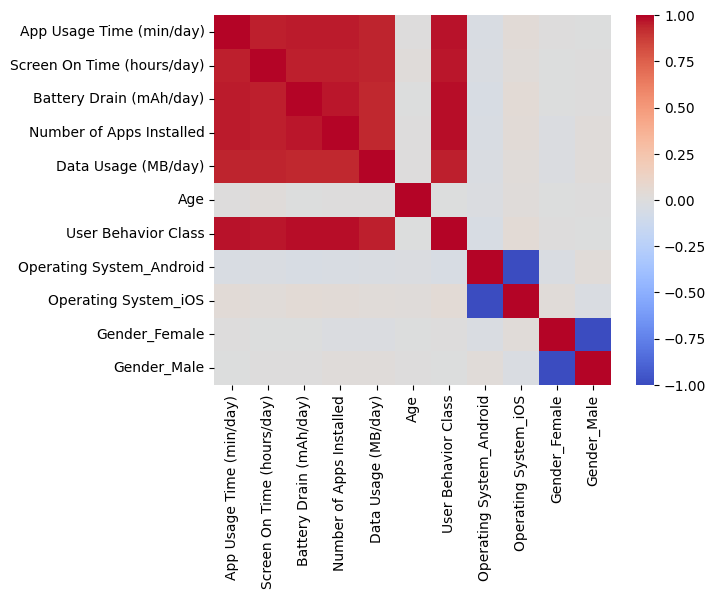

In [7]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix,cmap="coolwarm");

In [8]:
data = scale_data(data, "App Usage Time (min/day)")
data = scale_data(data, "Screen On Time (hours/day)")
data = scale_data(data, "Battery Drain (mAh/day)")
data = scale_data(data, "Number of Apps Installed")
data = scale_data(data, "Data Usage (MB/day)")
data = scale_data(data, "Age")

data = remove_outliers_by_zscore(data, "App Usage Time (min/day)")
data = remove_outliers_by_zscore(data, "Screen On Time (hours/day)")
data = remove_outliers_by_zscore(data, "Battery Drain (mAh/day)")
data = remove_outliers_by_zscore(data, "Number of Apps Installed")
data = remove_outliers_by_zscore(data, "Data Usage (MB/day)")
data = remove_outliers_by_zscore(data, "Age")

In [9]:
data.head()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class,Operating System_Android,Operating System_iOS,Gender_Female,Gender_Male,Zscore_App Usage Time (min/day),Zscore_Screen On Time (hours/day),Zscore_Battery Drain (mAh/day),Zscore_Number of Apps Installed,Zscore_Data Usage (MB/day),Zscore_Age
0,0.688256,0.367626,0.423726,0.606096,0.300405,0.126383,4,True,False,False,True,0.688256,0.367626,0.423726,0.606096,0.300405,0.126383
1,-0.017668,-0.186771,-0.237198,-0.322441,0.022277,0.709506,3,True,False,True,False,-0.017668,-0.186771,-0.237198,-0.322441,0.022277,0.709506
2,-0.661471,-0.415053,-0.933550,-0.693856,-0.949607,0.292989,2,True,False,False,True,-0.661471,-0.415053,-0.933550,-0.693856,-0.949607,0.292989
3,-0.181443,-0.154160,0.184279,0.197540,-0.091787,-1.539682,3,True,False,False,True,-0.181443,-0.154160,0.184279,0.197540,-0.091787,-1.539682
4,-0.475107,-0.317218,-0.193218,0.271823,0.091028,-0.623346,3,False,True,True,False,-0.475107,-0.317218,-0.193218,0.271823,0.091028,-0.623346


In [10]:
data = data.drop(["Zscore_App Usage Time (min/day)", "Zscore_Screen On Time (hours/day)",
                  "Zscore_Battery Drain (mAh/day)", "Zscore_Number of Apps Installed",
                  "Zscore_Data Usage (MB/day)", "Zscore_Age"], axis= 1)

data.head()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class,Operating System_Android,Operating System_iOS,Gender_Female,Gender_Male
0,0.688256,0.367626,0.423726,0.606096,0.300405,0.126383,4,True,False,False,True
1,-0.017668,-0.186771,-0.237198,-0.322441,0.022277,0.709506,3,True,False,True,False
2,-0.661471,-0.415053,-0.933550,-0.693856,-0.949607,0.292989,2,True,False,False,True
3,-0.181443,-0.154160,0.184279,0.197540,-0.091787,-1.539682,3,True,False,False,True
4,-0.475107,-0.317218,-0.193218,0.271823,0.091028,-0.623346,3,False,True,True,False


In [11]:
data.to_csv('newUserBehaviour.csv', index=False)

In [12]:
user_behaviour = pd.read_csv('newUserBehaviour.csv').dropna()
user_behaviour.head()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class,Operating System_Android,Operating System_iOS,Gender_Female,Gender_Male
0,0.688256,0.367626,0.423726,0.606096,0.300405,0.126383,4,True,False,False,True
1,-0.017668,-0.186771,-0.237198,-0.322441,0.022277,0.709506,3,True,False,True,False
2,-0.661471,-0.415053,-0.933550,-0.693856,-0.949607,0.292989,2,True,False,False,True
3,-0.181443,-0.154160,0.184279,0.197540,-0.091787,-1.539682,3,True,False,False,True
4,-0.475107,-0.317218,-0.193218,0.271823,0.091028,-0.623346,3,False,True,True,False


In [17]:
X = user_behaviour.drop(['User Behavior Class'],axis=True)
y = user_behaviour['User Behavior Class']

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.4,random_state=RANDOM_STATE)

GaussianNB Accuracy: 1.0


<Axes: >

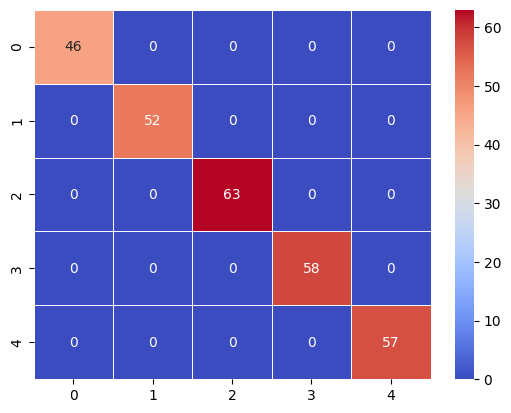

In [21]:
nb_model = GaussianNB()
nb_model.fit(Xtrain, ytrain)

y_pred = nb_model.predict(Xtest)

print("GaussianNB Accuracy:", accuracy_score(ytest, y_pred))

confusion = confusion_matrix(ytest, y_pred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

In [22]:
scores = cross_val_score(nb_model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0


Так как модель получилась очень хорошая мне показалось, что она переобучается

<Axes: >

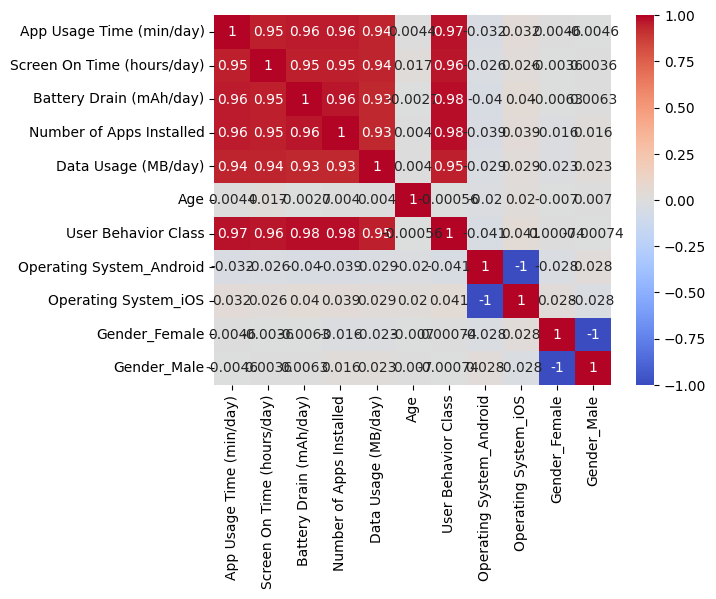

In [23]:
corr_matrix = user_behaviour.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Судя по данному графику, видно что UserBehaviour имеет высокую корреляцию с большинством признаком. Чтобы до конца убедится, что модель не переобучивается, я перемещал данные и проверил на переобучение

In [25]:
from sklearn.utils import shuffle
y_shuffled = shuffle(y)
scores_shuffled = cross_val_score(nb_model, X, y_shuffled, cv=5)
print("Cross-validation scores with shuffled target:", scores_shuffled)
print("Mean accuracy with shuffled target:", scores_shuffled.mean())

Cross-validation scores with shuffled target: [0.20289855 0.1884058  0.18115942 0.19565217 0.19565217]
Mean accuracy with shuffled target: 0.19275362318840578


Multinomial Naive Bayes Подходит для данных, где признаки представляют частоты или целочисленные значения

MultinomialNB Accuracy: 0.9178571428571428


<Axes: >

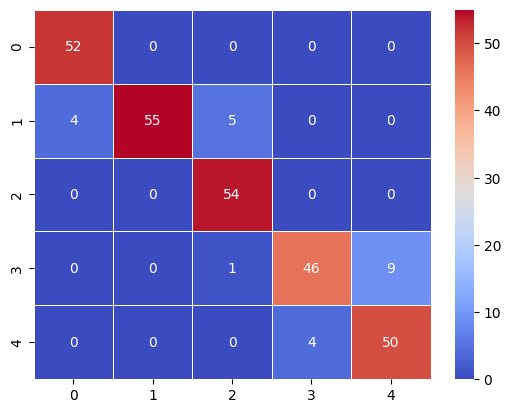

In [37]:
X = user_behaviour.drop(['User Behavior Class'],axis=True)
y = user_behaviour['User Behavior Class']
X_multinomial = X - X.min().min() + 1   # получаем + значения, ибо MultinomialNB 
                                        # не работает с числами < 0

Xtrain,Xtest,ytrain,ytest = train_test_split(X_multinomial,y,test_size=0.4,random_state=RANDOM_STATE)

model = MultinomialNB()
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)

print("MultinomialNB Accuracy:", accuracy_score(ytest, y_pred))

confusion = confusion_matrix(ytest, y_pred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)



Bernoulli Naive Bayes подходит для бинарных данных

MultinomialNB Accuracy: 0.5428571428571428


<Axes: >

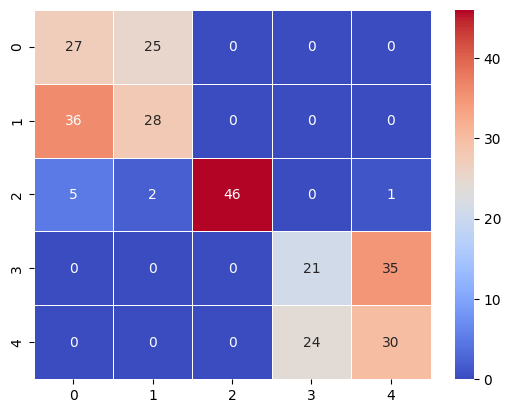

In [38]:
X = user_behaviour.drop(['User Behavior Class'],axis=True)
y = user_behaviour['User Behavior Class']
X_binary = (X > 0).astype(int)

Xtrain,Xtest,ytrain,ytest = train_test_split(X_binary,y,test_size=0.4,random_state=RANDOM_STATE)

multinomial_model = BernoulliNB()
multinomial_model.fit(Xtrain, ytrain)
y_pred = multinomial_model.predict(Xtest)

print("MultinomialNB Accuracy:", accuracy_score(ytest, y_pred))

confusion = confusion_matrix(ytest, y_pred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)


In [ ]:
X = user_behaviour.drop(['User Behavior Class'],axis=True)
y = user_behaviour['User Behavior Class']

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.4,random_state=RANDOM_STATE)

params = {
    "Decision_Tree": {'max_depth': range(1, 20), 'criterion': ['entropy', 'gini']},
    "KNN": {'n_neighbors': range(1, 32)},
    "Logistic_Regression": {'C': [0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', None]}
}

clf = {
    "Decision_Tree": GridSearchCV(DecisionTreeClassifier(), param_grid=params["Decision_Tree"], cv=10),
    "KNN": GridSearchCV(KNeighborsClassifier(), param_grid=params["KNN"], cv=10),
    "Logistic_Regression": GridSearchCV(LogisticRegression(penalty='l2', max_iter=10000), param_grid=params["Logistic_Regression"], cv=10)
}

for model_name in clf:
    print(f"Fitting {model_name}...")
    clf[model_name].fit(Xtrain, ytrain)

models = {
    "Decision_Tree": DecisionTreeClassifier(
        criterion=clf["Decision_Tree"].best_params_['criterion'],
        max_depth=clf["Decision_Tree"].best_params_['max_depth'],
        random_state=RANDOM_STATE
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=clf["KNN"].best_params_['n_neighbors']
    ),
    "Logistic_Regression": LogisticRegression(
        max_iter=10000,
        penalty='l2',
        class_weight=clf["Logistic_Regression"].best_params_['class_weight'],
        C=clf["Logistic_Regression"].best_params_['C']
    )
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    print(f"Accuracy for {name}: {accuracy_score(ytest, y_pred):.4f}")

Fitting Decision_Tree...
Fitting KNN...
Fitting Logistic_Regression...
Training Decision_Tree...
Accuracy for Decision_Tree: 0.9893
Training KNN...
Accuracy for KNN: 0.9964
Training Logistic_Regression...
Accuracy for Logistic_Regression: 1.0000


<Axes: >

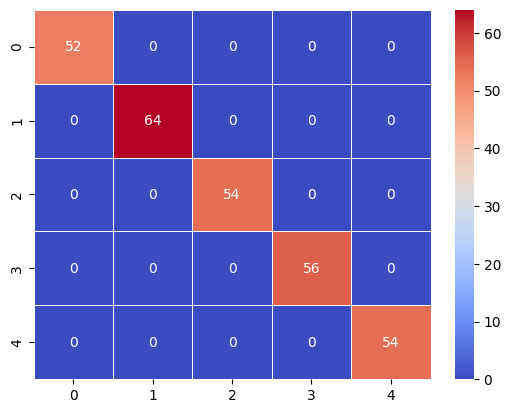

In [49]:
best_model = models["Logistic_Regression"]
y_pred = best_model.predict(Xtest)

confusion = confusion_matrix(ytest, y_pred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

Так как выше мы уже доказали, что данные у нас хорошо коррелируют с нужным признаком, то и логистическая регрессия хорошо отработала

## <font color = 'green'> 2. Проблема фильтрации спама </font>

Вся мощь наивного Байеса раскрывается, когда мы начинаем использовать различные распределения для различных фич.
В частности отдельного внимания заслуживает работа с категориальными фичами.
Рассмотрим задачу определения спама.

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

In [52]:
data = pd.read_csv("spam.csv",encoding='ISO-8859-1')

In [53]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [54]:
X = data["v2"].values
X[:3]

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
      dtype=object)

In [55]:
y = data['v1'].map({'ham':0,'spam':1}).values
y[:3]

array([0, 0, 1])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
def tokenize(message):
    message = message.lower()
    all_words = re.findall("[a-z0-9]+", message)
    return np.array(list(set(all_words)))
    

In [58]:
tokenize(X_train[0])

array(['at', 'same', 'me', 'half', 'i', 'here', 'my', 'on', 'naked', 'm',
       'no', 'yo', 'the', 'in', 'moms', 'boat', 'check', 'still', 'out'],
      dtype='<U5')

### <font color = 'red' size = 5>Задание 3 </font>


Для датасета данных из файла "spam.csv" построить модель классификатора на основе наивного Байеса.

1. Реализуйте самостоятельно модель классификации, не используя модели из sklearn. Подробнее [тут](https://www.bazhenov.me/blog/2012/06/11/naive-bayes.html)
2. Оцените качество модели.
3. Попробуйте реализовать подобный классификатор для данных об [отзывах на фильмы](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) из предыдущих ЛР.


In [61]:
spam = pd.read_csv("spam.csv", encoding='ISO-8859-1')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'<[^>]+>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'\W', ' ', text)  # Удаление символов
    text = re.sub(r'\s+', ' ', text)  # Удаление лишних пробелов
    return text.strip()

In [63]:
spam = spam[['v1', 'v2']]
spam.columns = ['label', 'message']

spam['label'] = spam['label'].map({'ham': 0, 'spam': 1})
spam['message'] = spam['message'].apply(preprocess_text)

spam.head()

,label,message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i don t think he goes to usf he lives arou...


In [7]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probs = {}  # Априорные вероятности классов
        self.word_probs = {}   # Условные вероятности слов
        
    def fit(self, X, y):
        # Подсчет априорных вероятностей классов
        class_counts = Counter(y)
        total_count = len(y)
        self.class_probs = {cls: count / total_count for cls, count in class_counts.items()}
        
        # Подсчет частот слов для каждого класса
        word_counts = {cls: defaultdict(int) for cls in class_counts}
        total_words = {cls: 0 for cls in class_counts}
        
        for text, label in zip(X, y):
            words = text.split()
            for word in words:
                word_counts[label][word] += 1
                total_words[label] += 1
        
        # Вычисление вероятностей слов
        vocab = set(word for wc in word_counts.values() for word in wc)
        self.word_probs = {
            cls: {word: (word_counts[cls][word] + 1) / (total_words[cls] + len(vocab))
                  for word in vocab}
            for cls in class_counts
        }
        
    def predict(self, X):
        predictions = []
        for text in X:
            words = text.split()
            class_scores = {}
            for cls in self.class_probs:
                # Начальная вероятность — априорная
                score = np.log(self.class_probs[cls])
                for word in words:
                    if word in self.word_probs[cls]:
                        score += np.log(self.word_probs[cls][word])
                class_scores[cls] = score
            predictions.append(max(class_scores, key=class_scores.get))
        return predictions

NaiveBayesClassifier Accuracy: 0.9868421052631579


<Axes: >

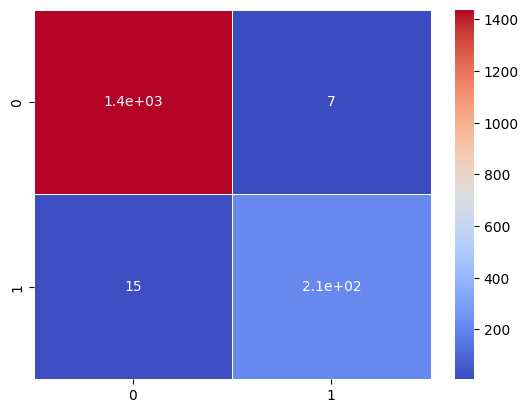

In [70]:
X_train, X_test, y_train, y_test = train_test_split(spam['message'], spam['label'], test_size=0.3, random_state=RANDOM_STATE)

nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
accuracy = np.mean(np.array(y_pred) == y_test.values)

print("NaiveBayesClassifier Accuracy:", accuracy)

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

In [12]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:

data['prep_review'] = data['review'].apply(preprocess_text)

X_text = data['prep_review'] 
Y = data['sentiment'].map({'positive': 1, 'negative': 0})  

# vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
# X = vectorizer.fit_transform(X_text)

# imdb = pd.DataFrame(data['review'])
# imdb['sentiment'] = Y.values
# imdb['tfidf_features'] = [X.getrow(i) for i in range(X.shape[0])] 

# imdb.head()
data.head()

,review,sentiment,prep_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is a...


NaiveBayesClassifier Accuracy: 0.8437


<Axes: >

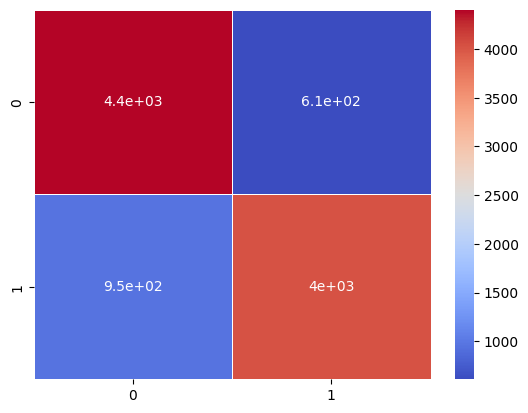

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_text, Y, test_size=0.2, random_state=RANDOM_STATE)

nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
accuracy = np.mean(np.array(y_pred) == y_test.values)

print("NaiveBayesClassifier Accuracy:", accuracy)

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

## <font color = 'green'> 3. Калибровка моделей по вероятности</font>

Проблема калибровки вероятностей моделей встаёт перед нами, когда нам важны вероятности предсказаний, а не только итоговое решение о классификации. На лекции был разобран пример, когда вероятности, которые возвращает *predict_proba* не соответсвуют реальному распределению на таргете. 
Подообнее [тут](https://habr.com/ru/companies/otus/articles/573924/)

In [17]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt

In [19]:
X, y = make_classification(n_samples=100_000, n_features=2, n_informative=2, n_redundant=0,random_state=12)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
y.shape

(100000,)

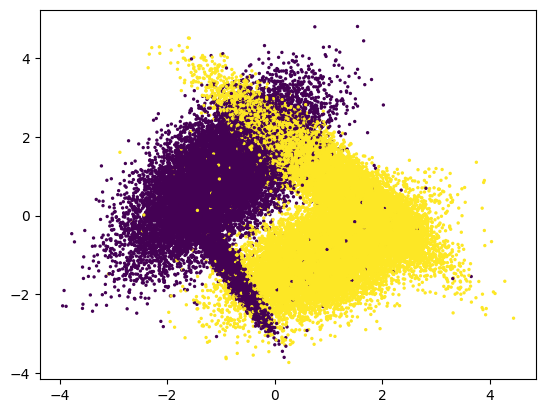

In [22]:
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,s=2)
plt.show()

In [23]:
from sklearn.naive_bayes import GaussianNB

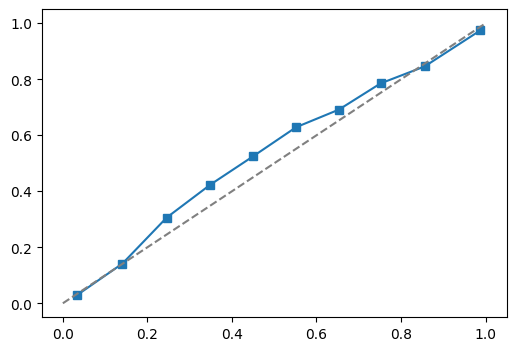

In [24]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.show()

### <font color = 'red' size = 5>Задание 4 </font>


1. На искусственных и реальных данных приведите пример на искусственных и реальных данных, когда модель плохо откалибрована. Графически подтвердите!
2. Используя изотоническую регрессию и логистическую регрессию исправьте калибровку моделей.
3. В чём принципиальная разница между данными подходами? Докажите вычислениями!

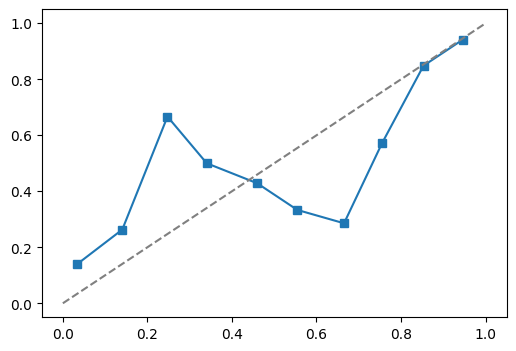

In [34]:
# Создаем искусственные данные
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_classes=2, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_probs_nb = nb_model.predict_proba(X_test)[:, 1]

# Калибровочная кривая
prob_true_nb, prob_pred_nb = calibration_curve(y_test, y_probs_nb, n_bins=10)

plt.figure(figsize=(6, 4))
plt.plot(prob_pred_nb, prob_true_nb, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.show()

In [32]:
data = pd.read_csv("IMDB Dataset.csv")  
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [37]:

data['prep_review'] = data['review'].apply(preprocess_text)

X_text = data['prep_review'] 
Y = data['sentiment'].map({'positive': 1, 'negative': 0})  

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(X_text)

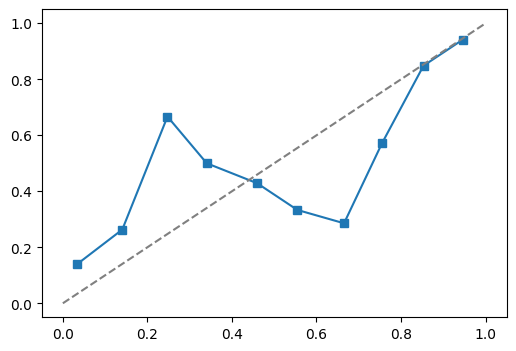

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

# Калибровочная кривая
prob_true_mnb, prob_pred_mnb = calibration_curve(y_test, y_pred, n_bins=10)

plt.figure(figsize=(6, 4))
plt.plot(prob_pred_nb, prob_true_nb, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.show()

In [48]:
data = pd.read_csv("IMDB Dataset.csv")  

data['prep_review'] = data['review'].apply(preprocess_text)
X_text = data['prep_review'] 
Y = data['sentiment'].map({'positive': 1, 'negative': 0})  

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(X_text)

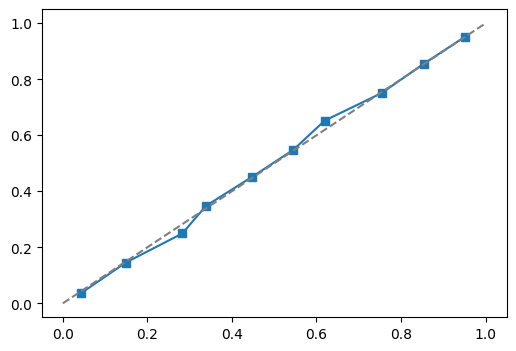

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

# Обучаем модель Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Калибровка с использованием логистической регрессии
calibrated_nb = CalibratedClassifierCV(nb, method='sigmoid', cv='prefit')
calibrated_nb.fit(X_train, y_train)

# Предсказание вероятностей для тестовой выборки
y_prob = calibrated_nb.predict_proba(X_test)[:, 1]

# Построение калибровочной кривой
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6, 4))
plt.plot(prob_true, prob_pred, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.show()

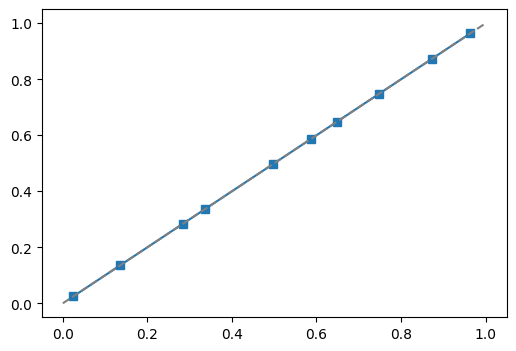

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

# Обучаем модель Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Калибровка с использованием логистической регрессии
iso_reg = IsotonicRegression(out_of_bounds='clip')
y_prob = nb.predict_proba(X_test)[:, 1]
y_prob_calibrated = iso_reg.fit_transform(y_prob, y_test)

# Построение калибровочной кривой
prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

plt.figure(figsize=(6, 4))
plt.plot(prob_true, prob_pred, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.show()

Сигмоидная функция (Logistic Regression)

$$σ(x) = \frac{1}{(1 + e^{-x})}$$

где
* $x$ — входное значение.
* $𝑒$ — основание натурального логарифма.
* $𝜎(𝑥)$ — выходное значение функции, представляющее вероятность.




Изотоническая регрессия

$$f(x) = \min{ ( y ∈ Y | y ≥ x) }$$

где:
* 𝑥 — предсказанная вероятность от модели.
* 𝑌 — множество наблюдаемых истинных меток классов (0 или 1).
* 𝑓(𝑥) — откалиброванное предсказание вероятности.


In [63]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_classes=2, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [64]:
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated.fit(X_test, y_test)

y_pred_proba_logreg = calibrated.predict_proba(X_test)[:, 1]

prob_true_logreg, prob_pred_logreg = calibration_curve(y_test, y_pred_proba_logreg, n_bins=10)

In [60]:
iso_reg = IsotonicRegression(out_of_bounds='clip')
y_prob = model.predict_proba(X_test)[:, 1]
y_prob_calibrated = iso_reg.fit_transform(y_prob, y_test)

prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

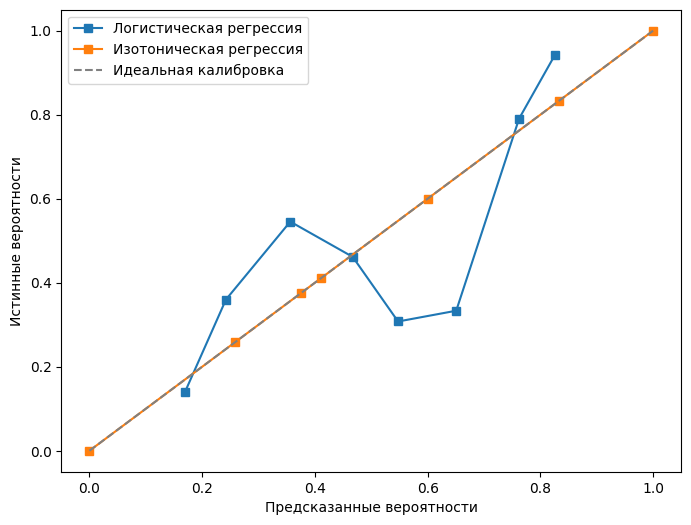

In [61]:
plt.figure(figsize=(8, 6))

# Графики
plt.plot(prob_pred_logreg, prob_true_logreg, 's-', label='Логистическая регрессия')
plt.plot(prob_pred_iso, prob_true_iso, 's-', label='Изотоническая регрессия')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Идеальная калибровка')

plt.xlabel('Предсказанные вероятности')
plt.ylabel('Истинные вероятности')
plt.legend()
plt.show()